In [1]:
# PyTorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scheduler - OneCycleLR, CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR, PolynomialLR
import lightning as L
import wandb

# Rich for console output
from rich.console import Console
from rich.progress import Progress

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import scienceplots
import numpy as np
import polars as pl

In [2]:
L.seed_everything(42)

Seed set to 42


42

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def load_data(file_path):
    df = pl.read_parquet(file_path)
    tensors = [torch.tensor(df[col].to_numpy().reshape(-1, 100), dtype=torch.float32) for col in df.columns]
    return tensors

In [5]:
train_tensors = load_data("../data/train.parquet")
val_tensors = load_data("../data/val.parquet")

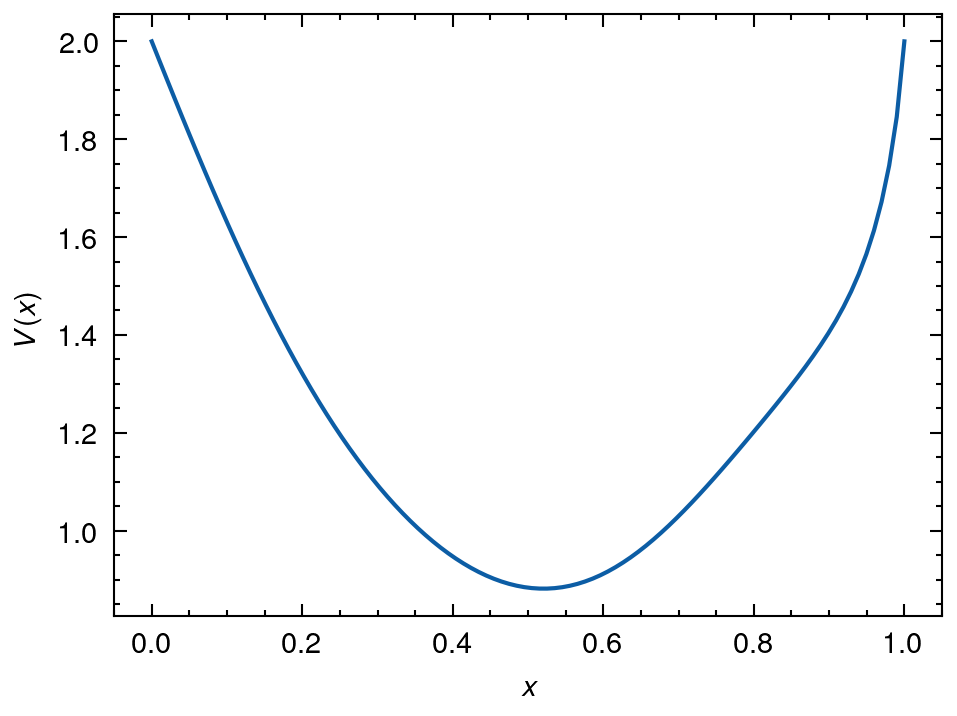

In [6]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(np.linspace(0, 1, 100), train_tensors[0][0])
    plt.xlabel(r"$x$")
    plt.ylabel(r"$V(x)$")
    plt.tight_layout()
    plt.savefig("../figs/potential.png", dpi=600)
    plt.show()

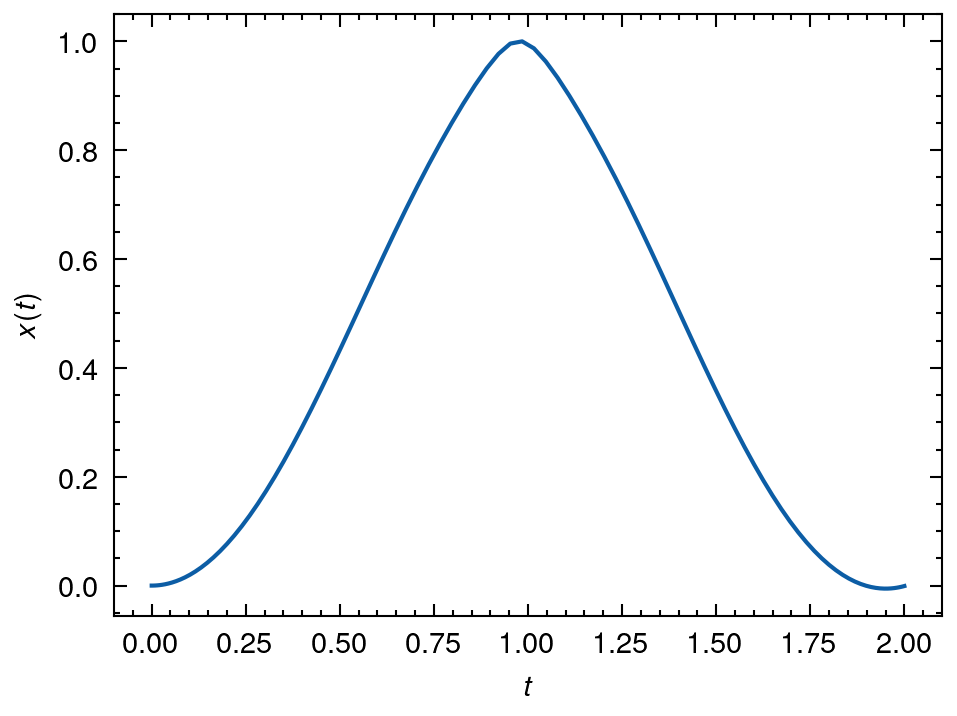

In [7]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(train_tensors[1][0], train_tensors[2][0])
    plt.xlabel(r"$t$")
    plt.ylabel(r"$x(t)$")
    plt.tight_layout()
    plt.savefig("../figs/trajectory.png", dpi=600)
    plt.show()

In [8]:
ds_train = TensorDataset(*train_tensors)
ds_val = TensorDataset(*val_tensors)

In [9]:
dl_train = DataLoader(ds_train, batch_size=500, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=500)

In [10]:
def create_net(sizes):
    net = []
    for i in range(len(sizes)-1):
        net.append(nn.Linear(sizes[i], sizes[i+1]))
        if i < len(sizes)-2:
            net.append(nn.GELU())
    return nn.Sequential(*net)

class DeepONet(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        
        self.branch_net = create_net([hparams["num_input"]] + [hparams["hidden_size"]]*(hparams["hidden_depth"]-1) + [hparams["num_branch"]]) 
        self.trunk_net = create_net([hparams["dim_output"]] + [hparams["hidden_size"]]*(hparams["hidden_depth"]-1) + [hparams["num_branch"]])
        self.bias = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, u, y):  
        l = y.shape[1]
        branch_out = self.branch_net(u) 
        trunk_out = torch.stack([self.trunk_net(y[:, i:i+1]) for i in range(l)], dim=2)
        pred = torch.einsum("bp,bpl->bl", branch_out, trunk_out) + self.bias
        return pred

In [11]:
def train_epoch(model, optimizer, dataloader, device):
    model.train()
    epoch_loss = 0
    for u, y, Guy in dataloader:  
        optimizer.zero_grad()
        pred = model(u.to(device), y.to(device))
        loss = F.mse_loss(pred, Guy.to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    return epoch_loss

def evaluate(model, dataloader, device):
    model.eval()  
    eval_loss = 0
    with torch.no_grad():
        for u, y, Guy in dataloader:
            pred = model(u.to(device), y.to(device))
            loss = F.mse_loss(pred, Guy.to(device)) 
            eval_loss += loss.item()
    eval_loss /= len(dataloader)
    return eval_loss

In [12]:
hparams = {
    "num_input": 100,
    "num_branch": 10,
    "num_output": 100,
    "dim_output": 1,
    "hidden_size": 32,
    "hidden_depth": 10,
    "learning_rate": 1e-2,
    "batch_size": 500,
    "epochs": 200
}

In [13]:
model = DeepONet(hparams)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])
scheduler = PolynomialLR(optimizer, total_iters=int(hparams["epochs"]), power=2.0)
# scheduler = OneCycleLR(optimizer, max_lr=hparams["learning_rate"], epochs=hparams["epochs"], steps_per_epoch=1)

run_name = f"bezier_{hparams['hidden_size']}_{hparams['hidden_depth']}"
wandb.init(project="DeepONet-Hamilton-Bound", config=hparams, name=run_name)

for epoch in range(hparams["epochs"]):
    train_loss = train_epoch(model, optimizer, dl_train, device)
    val_loss = evaluate(model, dl_val, device)
    scheduler.step()
    wandb.log({"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch+1, "lr": scheduler.get_last_lr()[0]})

wandb.finish()

# Save
torch.save(model.state_dict(), f"../checkpoints/{run_name}.pth")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,200
lr,0.0
train_loss,0.00349
val_loss,0.01283


In [14]:
model.eval()

DeepONet(
  (branch_net): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
  (trunk_net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [15]:
(u_test, y_test, Guy_test) = next(iter(dl_val))

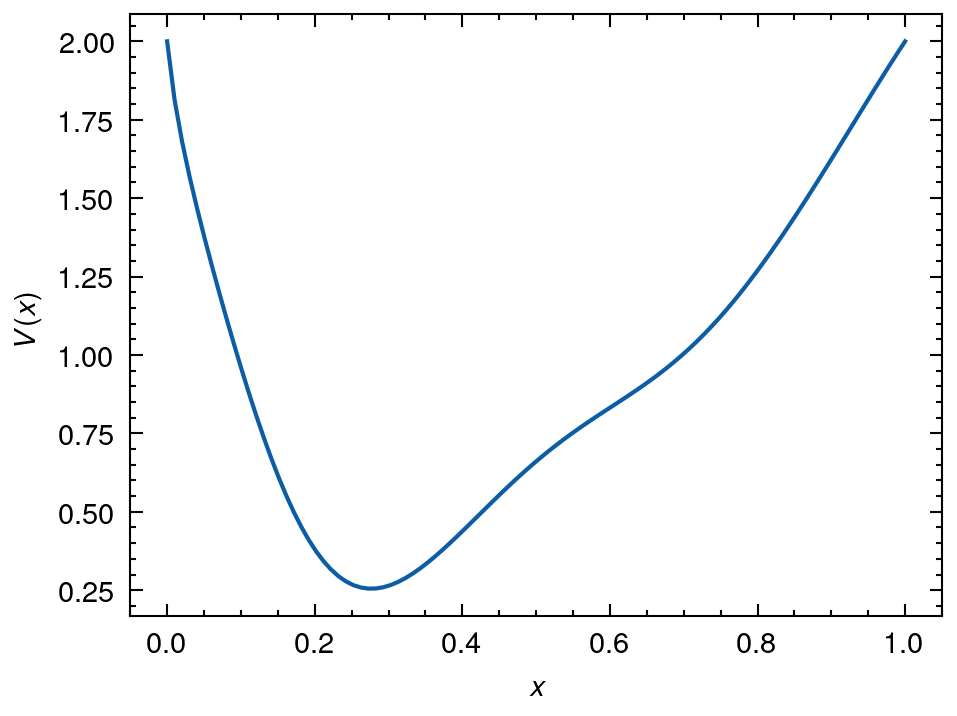

In [16]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(np.linspace(0, 1, 100), u_test[0].cpu().numpy())
    plt.xlabel(r"$x$")
    plt.ylabel(r"$V(x)$")
    plt.tight_layout()
    plt.savefig("../figs/potential_test.png", dpi=600)
    plt.show()

In [17]:
with torch.no_grad():
    Guy_hat = model(u_test[0:1,:].to(device), y_test[0:1,:].to(device))

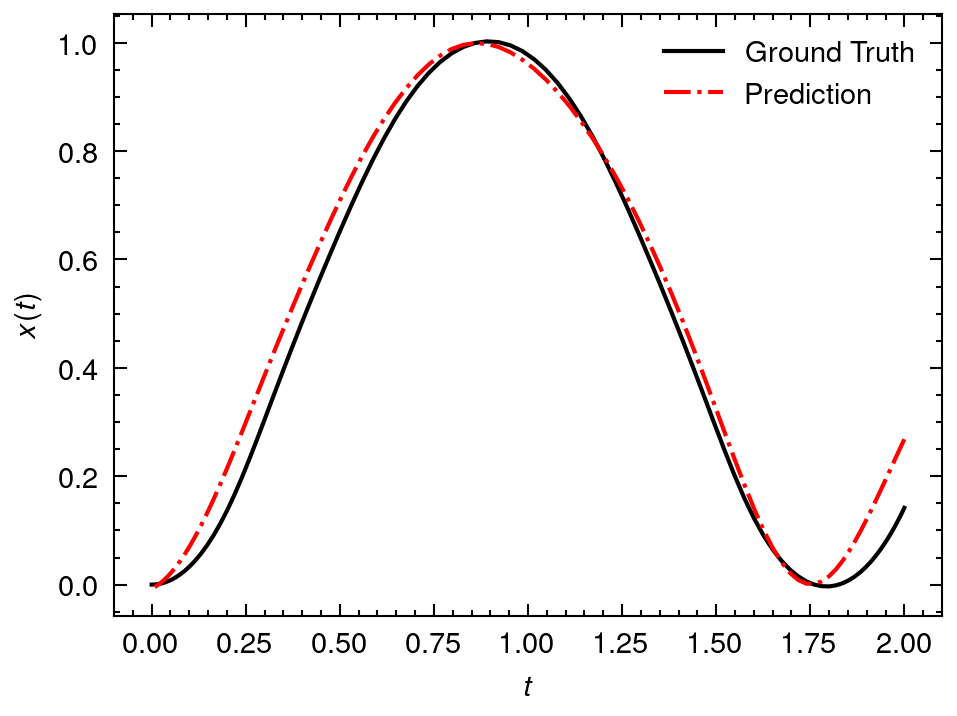

In [18]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(y_test[0].cpu().numpy(), Guy_test[0].cpu().numpy(), 'k-', label="Ground Truth")
    plt.plot(y_test[0].cpu().numpy(), Guy_hat.cpu().numpy().flatten(), 'r-.', label="Prediction")
    plt.xlabel(r"$t$")
    plt.ylabel(r"$x(t)$")
    plt.legend()
    plt.tight_layout()
    plt.savefig("../figs/trajectory_test.png", dpi=600)
    plt.show()

## Custom Test

$$
\begin{aligned}
&V(x) = 8 (x - 0.5)^2,~ x(0) = 0,~ x'(0) = 0 \\
&x'' = -V'(x) = -16 (x - 0.5) \\
\Rightarrow ~ &x(t) = 0.5 - 0.5 \cos(4t)
\end{aligned}
$$

In [19]:
x = torch.linspace(0, 1, 100).view(1, -1)
u = 8 * (x-0.5)**2
y = torch.linspace(0, 2, 100).view(1, -1)
Guy = 0.5 - 0.5 * torch.cos(4 * y)

with torch.no_grad():
    Guy_hat = model(u.to(device), y.to(device))

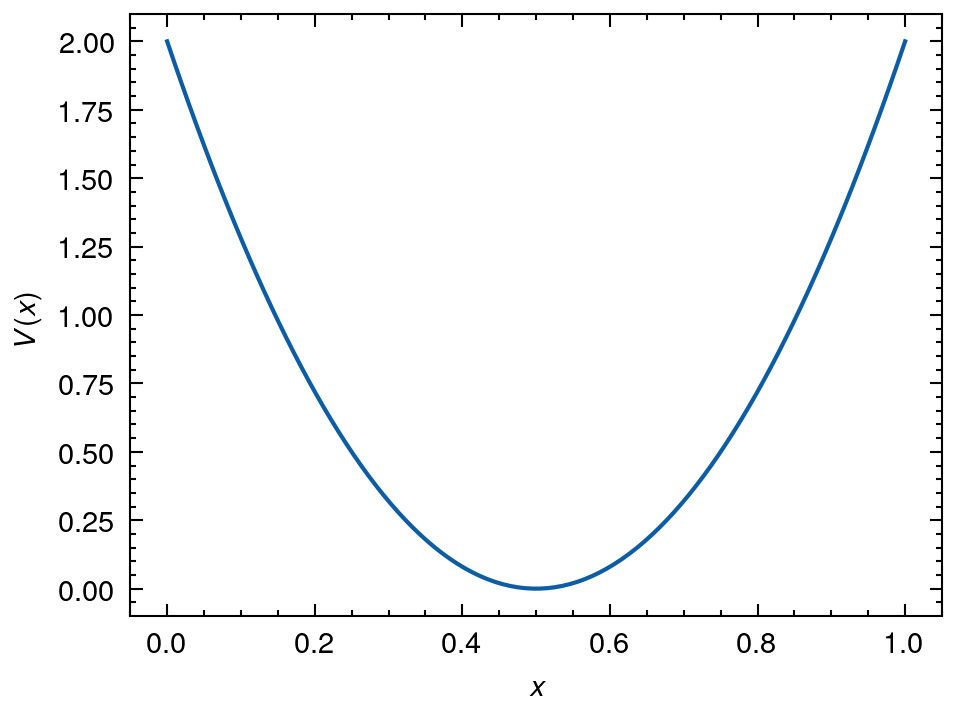

In [20]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(x.cpu().numpy().flatten(), u.cpu().numpy().flatten())
    plt.xlabel(r"$x$")
    plt.ylabel(r"$V(x)$")
    plt.tight_layout()
    plt.savefig("../figs/potential_pred.png", dpi=600)
    plt.show()

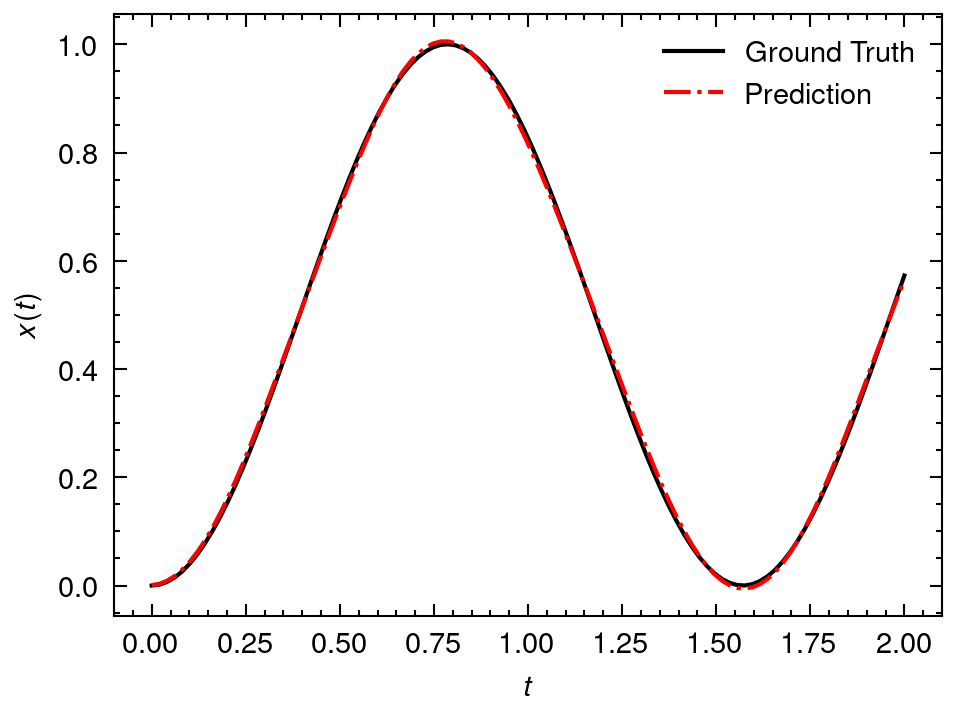

In [21]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(y.cpu().numpy().flatten(), Guy.cpu().numpy().flatten(), 'k-', label="Ground Truth")
    plt.plot(y.cpu().numpy().flatten(), Guy_hat.cpu().numpy().flatten(), 'r-.', label="Prediction")
    plt.xlabel(r"$t$")
    plt.ylabel(r"$x(t)$")
    plt.legend()
    plt.tight_layout()
    plt.savefig("../figs/trajectory_pred.png", dpi=600)
    plt.show()

## Custom Test 2

$$
\begin{aligned}
&V(x) = 4|x - 0.5|,~ x(0) = 0,~ x'(0) = 0 \\
&x'' = -V'(x) = \begin{cases} 4, & x < 0.5 \\ -4, & x > 0.5 \end{cases} \\
\Rightarrow ~ &x(t) = \begin{cases} 2t^2 & 0 < t < 0.5 \\ -2t^2 + 4t - 1& 0.5 \leq t < 1 \end{cases}
\end{aligned}
$$

In [22]:
x = torch.linspace(0, 1, 100).view(1, -1)
u = 4 * torch.abs(x - 0.5)
y = torch.linspace(0, 2, 100).view(1, -1)
Guy = torch.zeros_like(y)
Guy[y < 0.5] = 2 * y[y < 0.5] ** 2
ics = (y >= 0.5) & (y < 1.5)
Guy[ics] = -2 * y[ics]**2 + 4 * y[ics] - 1
ics = y >= 1.5
Guy[ics] = 2 * (2 - y[ics])**2

with torch.no_grad():
    Guy_hat = model(u.to(device), y.to(device))

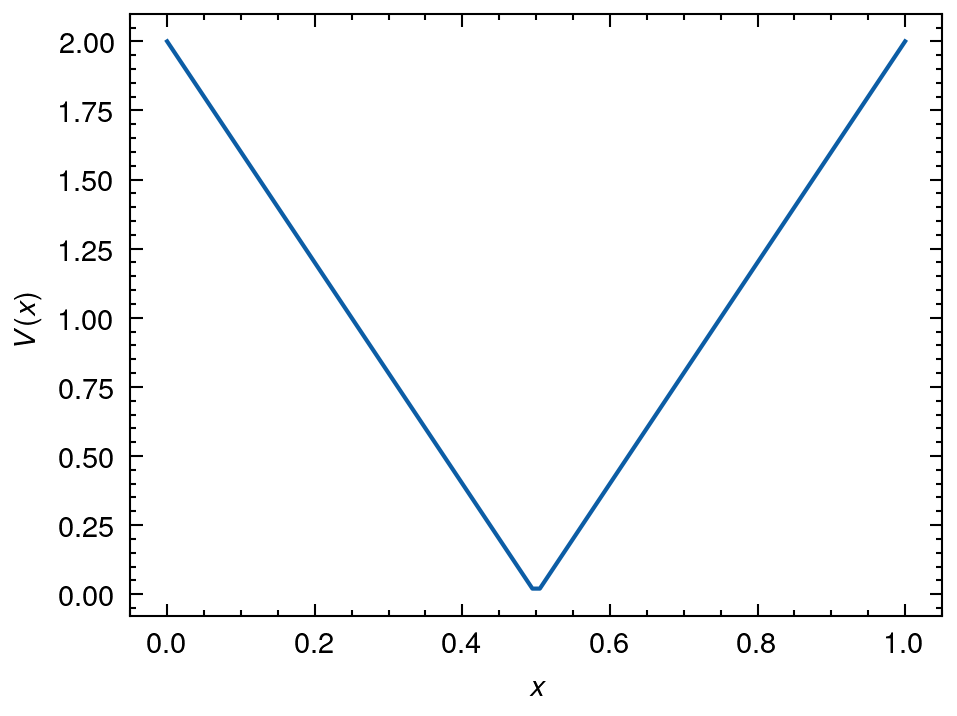

In [23]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(x.cpu().numpy().flatten(), u.cpu().numpy().flatten())
    plt.xlabel(r"$x$")
    plt.ylabel(r"$V(x)$")
    plt.tight_layout()
    plt.savefig("../figs/potential_pred2.png", dpi=600)
    plt.show()

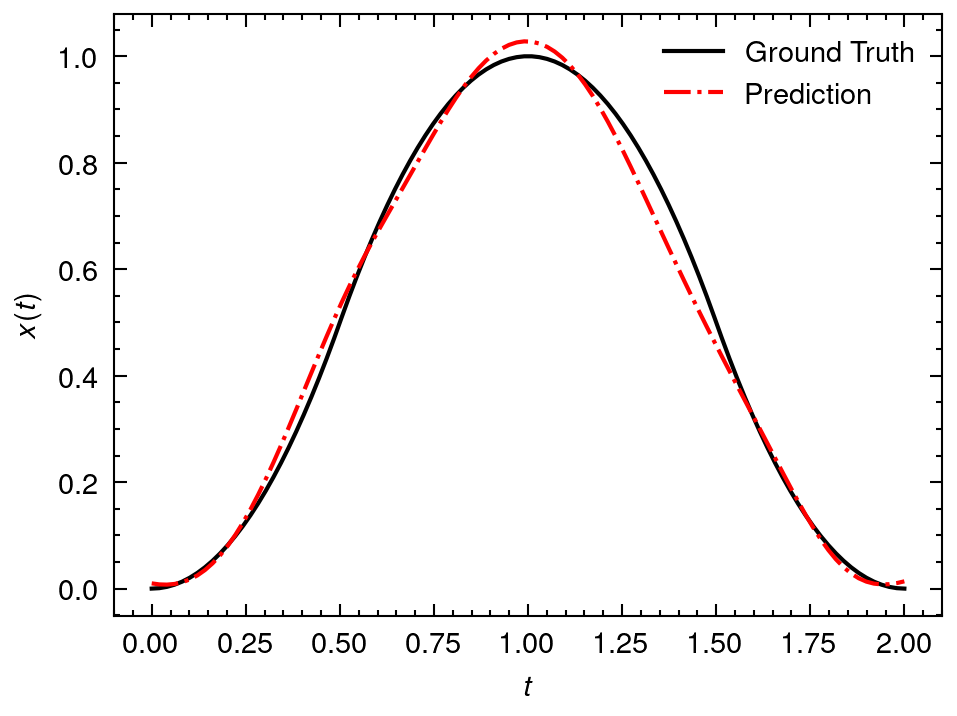

In [24]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(y.cpu().numpy().flatten(), Guy.cpu().numpy().flatten(), 'k-', label="Ground Truth")
    plt.plot(y.cpu().numpy().flatten(), Guy_hat.cpu().numpy().flatten(), 'r-.', label="Prediction")
    plt.xlabel(r"$t$")
    plt.ylabel(r"$x(t)$")
    plt.legend()
    plt.tight_layout()
    plt.savefig("../figs/trajectory_pred2.png", dpi=600)
    plt.show()

## Custom Test 3

$$
\begin{aligned}
&V(x) = \frac{625}{8}\left(x - \frac{1}{5}\right)^2\left(x-\frac{4}{5}\right)^2, ~ x(0) = 0, ~ \dot{x}(0) = 0 \\
\Rightarrow ~ &
\begin{cases}
\dot{x} = p \\
\dot{p} = -V'(x) = -\dfrac{625}{2}x^3 + \dfrac{1875}{4}x^2 - \dfrac{825}{4}x + 25
\end{cases}
\end{aligned}
$$

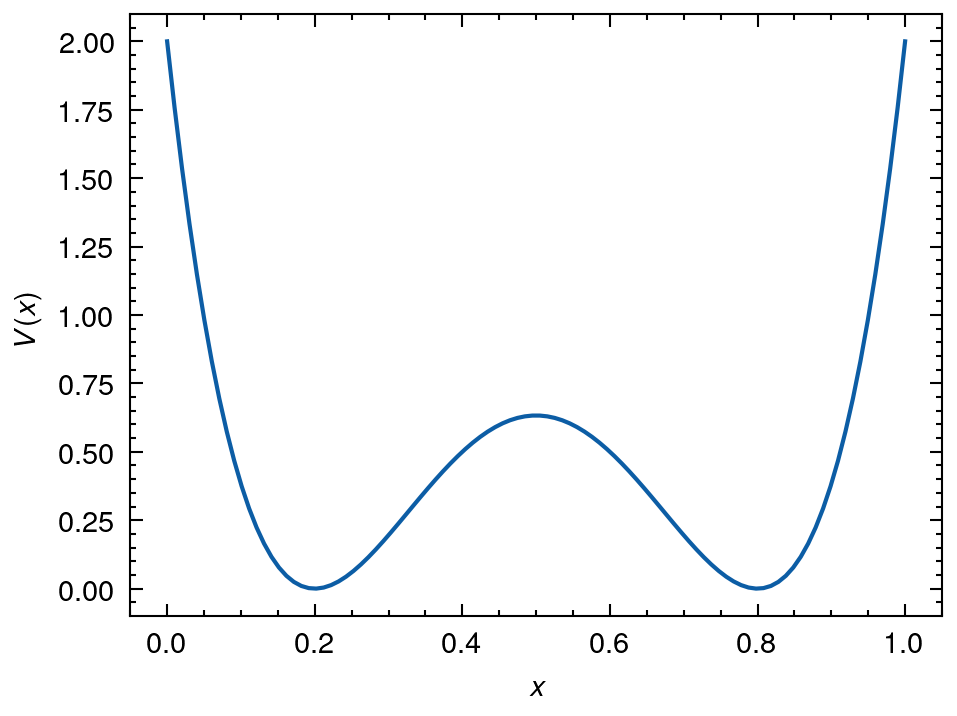

In [25]:
def V(x):
    return 625/8 * (x - 1/5)**2 * (x - 4/5)**2

x = np.linspace(0, 1, 100)

with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(x, V(x))
    plt.xlabel(r"$x$")
    plt.ylabel(r"$V(x)$")
    plt.tight_layout()
    plt.savefig("../figs/potential_pred3.png", dpi=600)
    plt.show()

In [26]:
from scipy.integrate import odeint

def dydt(y, t):
    x, p = y
    dxdt = p
    dpdt = -625/2 * x**3 + 1875/4 * x**2 - 825/4 * x + 25
    return [dxdt, dpdt]

y0 = [0, 0]  # 초기 조건: x(0) = 0, x'(0) = 0
t = np.linspace(0, 2, 100)  # 시간 범위 설정
sol = odeint(dydt, y0, t)

x_true = sol[:,0]
p_true = sol[:,1]

In [27]:
x = torch.linspace(0, 1, 100).view(1, -1)
u = V(x)
y = torch.linspace(0, 2, 100).view(1, -1)
Guy = torch.tensor(x_true).view(1, -1)

with torch.no_grad():
    Guy_hat = model(u.to(device), y.to(device))

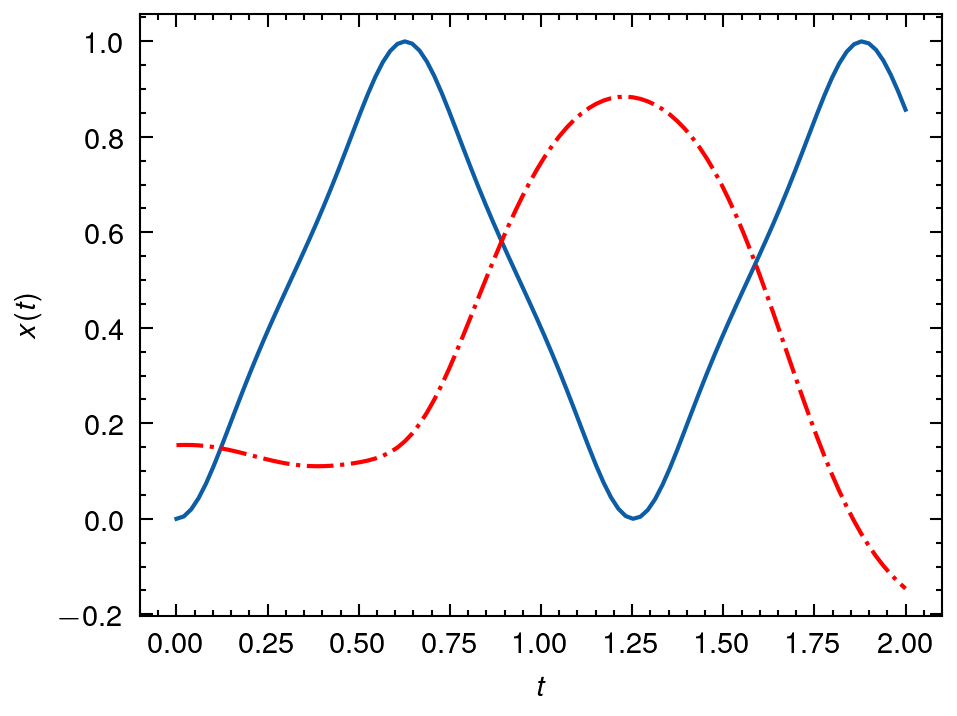

In [28]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(t, x_true)
    plt.plot(y.cpu().numpy().flatten(), Guy_hat.cpu().numpy().flatten(), 'r-.')
    plt.xlabel(r"$t$")
    plt.ylabel(r"$x(t)$")
    plt.tight_layout()
    plt.savefig("../figs/trajectory_pred3.png", dpi=600)
    plt.show()